In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf;
from tqdm import tqdm
import time

In [2]:
path = os.getcwd()
path

'/home/laurens/Sync/Master Data Science and Entrepreneurship/Master DSE/Thesis/ente/Face Recognition'

In [3]:
# To speed up the notebook, set this value to True to skip intermediate demo steps and only run full pipeline at the end of this notebook
skip_intermediate_demo = True

## Load data

LFW subset locally downloaded

In [4]:
# Path to the directory containing the subset of LFW dataset
# dataset = 'lfw_10classes_20images'
dataset = 'lfw_30classes_20images'
# dataset = 'lfw_10images'
# dataset = 'lfw_original' # crashes the kernel, try in Paperspace!
data_path = path + '/data/' + dataset + '/'

In [5]:
# Load the subset data into a NumPy array
data = []
original_images = []
targets = []
targets = []
for subdir in os.listdir(data_path):
    subdir_path = os.path.join(data_path, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(RGB_img.flatten())
                original_images.append(RGB_img)
                targets.append(subdir)

data = np.array(data)
original_images = np.array(original_images)

### Explore data

In [6]:
# introspect the images arrays to find the shapes (for plotting)
n, w, h, c = original_images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = data
n_features = X.shape[1]

# the label to predict is the id of the person
target_names = targets
target_names_unique = [target_name for target_name in set(target_names)]
y = LabelEncoder().fit_transform(target_names.copy())
target_names_first_index = [np.where(y == label)[0][0] for label in np.unique(y)]
target_names_first_index.sort()

n_classes = len(target_names_unique)

subdir_counts = {subdir: targets.count(subdir) for subdir in set(targets)}
n_classes_larger_than_5 = len([count for count in subdir_counts.values() if count >= 5])
n_classes_larger_than_10 = len([count for count in subdir_counts.values() if count >= 10])
n_images_from_classes_smaller_than_5 = sum([count for count in subdir_counts.values() if count < 5])
n_images_from_classes_smaller_than_10 = sum([count for count in subdir_counts.values() if count < 10])

In [7]:
# Print the shape of the data array
print('Data shape:', data.shape)

# Print the list of subdirectories and the number of images per subdirectory
print('Subdirectory counts (unordered):', subdir_counts,'\n')

print(f"There are {n} images in the dataset, {13233 - n} less than the original dataset (of 13233).")
print(f"Each image is {w} pixels wide and {h} pixels tall, with {c} channels (RGB).")
print(f"In total this gives us {n_features} features per image.")
print(f"There are {n_classes} unique targets (classes) in the dataset, of which {n_classes_larger_than_5} have at least five images, and {n_classes_larger_than_10} have at least ten images.")
print(f"There are {n_images_from_classes_smaller_than_5} images from classes with less than five images, and {n_images_from_classes_smaller_than_10} images from classes with less than ten images.")

Data shape: (1849, 187500)
Subdirectory counts (unordered): {'Angelina_Jolie': 20, 'Jeremy_Greenstock': 24, 'Hans_Blix': 39, 'George_W_Bush': 530, 'Carlos_Menem': 21, 'Alvaro_Uribe': 35, 'Jennifer_Lopez': 21, 'George_Robertson': 22, 'Andre_Agassi': 36, 'Jennifer_Aniston': 21, 'Gloria_Macapagal_Arroyo': 44, 'Arnold_Schwarzenegger': 42, 'Hamid_Karzai': 22, 'Hugo_Chavez': 71, 'Guillermo_Coria': 30, 'Atal_Bihari_Vajpayee': 24, 'Jacques_Chirac': 52, 'Amelie_Mauresmo': 21, 'Jennifer_Capriati': 42, 'Gray_Davis': 26, 'Colin_Powell': 236, 'Jack_Straw': 28, 'Jean_Chretien': 55, 'Bill_Clinton': 29, 'David_Beckham': 31, 'Donald_Rumsfeld': 121, 'Igor_Ivanov': 20, 'Ariel_Sharon': 77, 'Gerhard_Schroeder': 109} 

There are 1849 images in the dataset, 11384 less than the original dataset (of 13233).
Each image is 250 pixels wide and 250 pixels tall, with 3 channels (RGB).
In total this gives us 187500 features per image.
There are 29 unique targets (classes) in the dataset, of which 29 have at least fi

In [8]:
original_images.shape

(1849, 250, 250, 3)

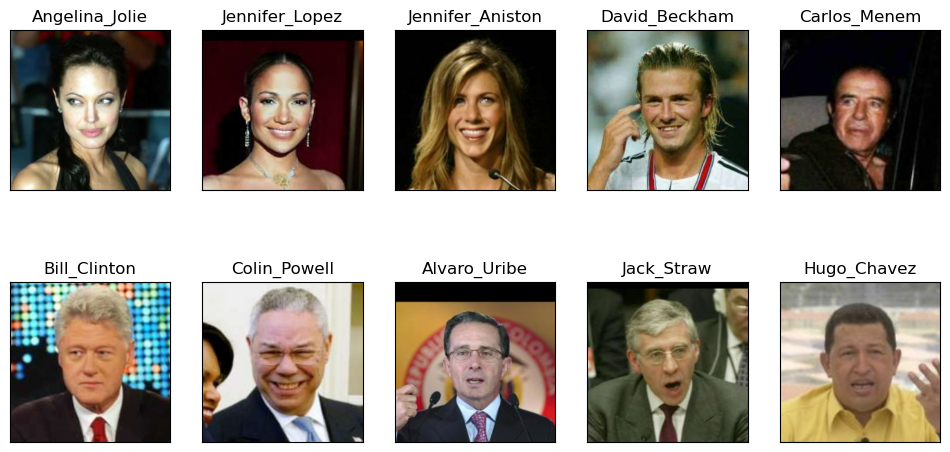

In [9]:
plot_images = original_images[target_names_first_index[0:10]]
label_array = np.array(target_names)[target_names_first_index[0:10]]

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate over the subplots and plot each image with its corresponding label
for i, ax in enumerate(axes.flat):
    ax.imshow(plot_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(label_array[i]))

# Show the figure
plt.show()

In [10]:
original_images.shape

(1849, 250, 250, 3)

In [11]:
# the channels: RGB
original_images[0,0,0,:]

array([ 0, 16, 27], dtype=uint8)

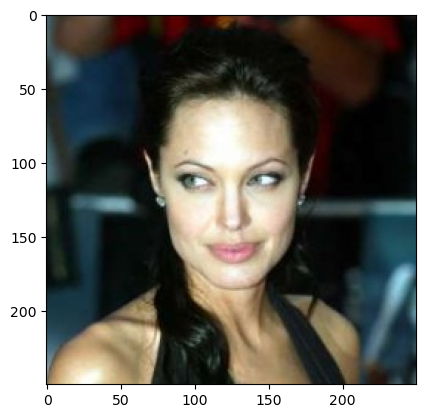

In [12]:
plt.imshow(original_images[0])

(array([[ 62.,  81.,  57., ...,   0.,   0.,   0.],
        [ 63.,  83.,  58., ...,   0.,   0.,   0.],
        [ 59.,  90.,  68., ...,   0.,   0.,   0.],
        ...,
        [140.,  72.,  21., ...,   0.,   0.,   0.],
        [128.,  78.,  27., ...,   0.,   0.,   0.],
        [121.,  76.,  28., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 250 BarContainer objects>)

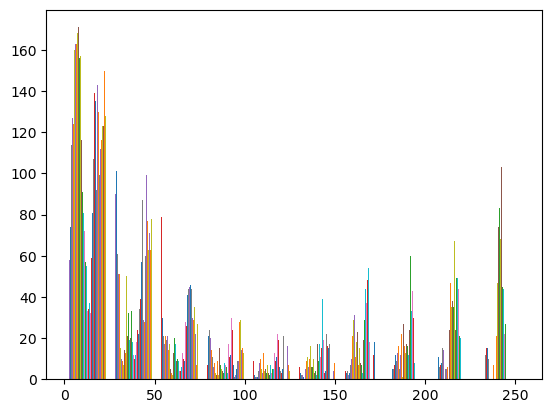

In [13]:
plt.hist(original_images[0,:,:,0])

In [14]:
def plot_original_faces(indices, max_faces=None, start=0):
    # Get the relevant images from the original_images array
    relevant_images = original_images[indices[start:]]
    
    # If max_faces is set, limit the number of images to plot
    if max_faces is not None:
        relevant_images = relevant_images[:max_faces]
    
    # Determine the number of rows and columns to use in the plot
    num_images = relevant_images.shape[0]
    num_cols = min(num_images, 5)
    num_rows = int(np.ceil(num_images / num_cols))
    
    # Create the plot and add subplots for each image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, img in enumerate(relevant_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    
    # Remove any unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

## Preprocess the images

## Face detection
Based on BlazeFace, taken inspiration from [this repo](https://github.com/ibaiGorordo/BlazeFace-TFLite-Inference). 

In [15]:
from importlib import reload
from src.blazeface import BlazeFace, BlazeFaceResults
# reload(src.BlazeFace.BlazeFace)
# reload(BlazeFaceResults)

In [16]:
blazeface_model = BlazeFace(model_type='sparse')
blazeface_model.input_details

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [17]:
original_test_image = original_images[0]
test_image = blazeface_model.preprocess_input(original_test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


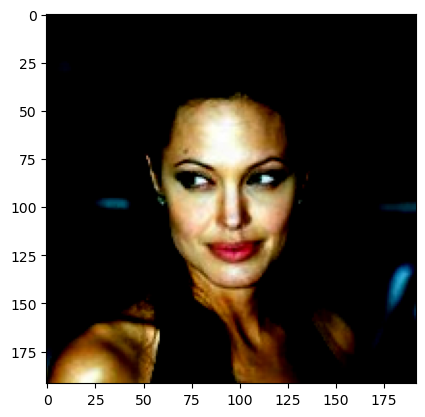

In [18]:
plt.imshow(test_image.numpy().squeeze()) if test_image.shape[0] == 1 else plt.imshow(test_image[0])

#### Extract detections

In [19]:
face_detection_results = blazeface_model.detect_faces(original_test_image)

In [20]:
face_detection_results.boxes

array([[0.27546662, 0.2826456 , 0.72875975, 0.73578474]])

In [21]:
face_detection_results.keypoints

array([[[0.40977376, 0.46071052],
        [0.59469746, 0.44891874],
        [0.50830729, 0.58337749],
        [0.50783263, 0.64816903],
        [0.31993453, 0.47233011],
        [0.68243349, 0.45063365]]])

In [22]:
face_detection_results.scores

array([0.90615994], dtype=float32)

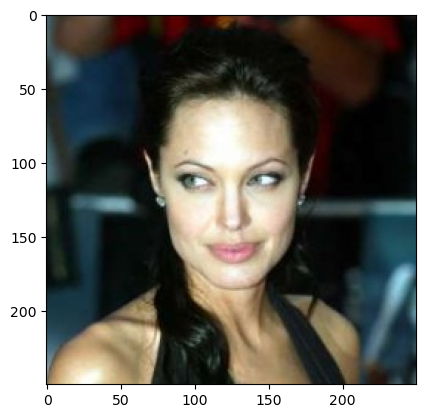

In [23]:
plt.imshow(original_test_image)

In [24]:
plot_test_image = blazeface_model.draw_detections_single_image(original_test_image, face_detection_results)

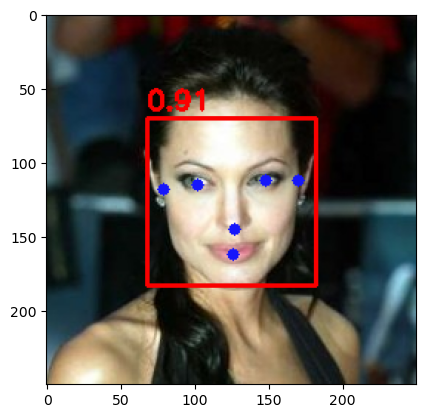

In [25]:
plt.imshow(plot_test_image)

#### Test detections

In [26]:
if not skip_intermediate_demo:
    blazeface_dense_model = BlazeFace(model_type='dense', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_dense_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"For the dense model:")
    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

In [27]:
if not skip_intermediate_demo:
    blazeface_model = BlazeFace(model_type='sparse', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

In [28]:
def plot_face_detections(indices, title, images=original_images, labels=target_names):
    
    plot_images = images[indices]
    label_array = np.array(labels)[indices]
    
    num_images = plot_images.shape[0]

    for i in range(num_images):
        detection_result = blazeface_model.detect_faces(plot_images[i])
        plot_images[i] = blazeface_model.draw_detections_single_image(plot_images[i], detection_result)

    # Calculate the number of rows and columns for the grid
    cols = min(5, num_images)
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Customize the background color and text color
    bg_color = "#222222"
    text_color = "#ffffff"

    fig.patch.set_facecolor(bg_color)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Plot the image
            if plot_images.shape[-1] == 3:
                ax.imshow(plot_images[i].astype(np.uint8))
            else:
                ax.imshow(plot_images[i], cmap='gray')
            
            # Set the title with the corresponding label
            ax.set_title(f"{label_array[i]}", fontsize=12, color=text_color, y=1.02)
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Set the background color for each subplot
        ax.set_facecolor(bg_color)

        # Set the color of the spines (border of the subplots)
        ax.spines['bottom'].set_color(text_color)
        ax.spines['top'].set_color(text_color)
        ax.spines['right'].set_color(text_color)
        ax.spines['left'].set_color(text_color)

    fig.suptitle(title, fontsize=20, y=1.02 + 0.02 * rows, color=text_color)
    plt.tight_layout(rect=[0, 0, 1, 1 - 0.04 * rows])
    plt.show()


In [29]:
if not skip_intermediate_demo:
    plot_face_detections(target_names_first_index, "Detected faces")

In [30]:
if not skip_intermediate_demo:
    plot_face_detections(undetected_faces_indices, "Undetected faces")

In [31]:
if not skip_intermediate_demo:
    plot_face_detections(double_detected_faces_indices, "Double face detections")

## Face alignment

For now I'm simply following [this github](https://sefiks.com/2020/02/23/face-alignment-for-face-recognition-in-python-within-opencv/) script from insightface.

In [32]:
from src.face_alignment import SimpleFaceAlignment

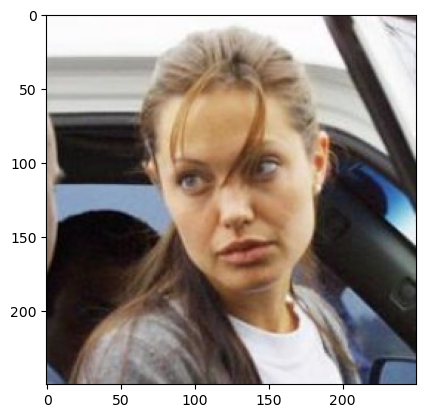

In [33]:
test_image = original_images[18]
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
plt.imshow(test_image)

In [34]:
face_aligner = SimpleFaceAlignment()

In [35]:
test_aligned_image_results = face_aligner.crop_and_align(test_image, test_image_face_detection_result)
test_aligned_image_results.aligned_faces[0].shape

(121, 121, 3)

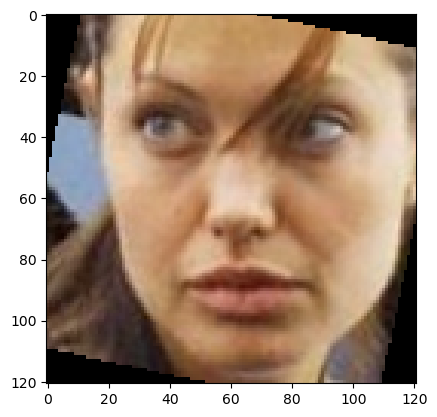

In [36]:
plt.imshow(test_aligned_image_results.aligned_faces[0])

In [37]:
test_aligned_image_results

AlignedFaceResults(
  num_faces=1,  # Number of detected faces
  eye_coordinates=[((37, 48), (85, 38))],  # (Left eye, Right eye)(from viewer perspective) coordinates for each face (x,y)
  rotation_angles=[11.768288932020639],  # Rotation angles for each face alignment
  relative_face_sizes=[0.234256]  # Relative size of each face compared to the original image
)

#### Test alignments

In [38]:
if not skip_intermediate_demo:
    face_detection_results = []
    face_alignment_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_alignment_results.append(face_aligner.crop_and_align(image, face_detection_results[idx]))
        else:
            face_alignment_results.append(None)
    

In [39]:
def plot_aligned_faces(aligned_face_results_list, max_faces=None, indices=None, start=0):
    if indices is not None:
        aligned_face_results_list = [aligned_face_results_list[i] for i in indices]

    aligned_faces = [
        face
        for aligned_face_results in aligned_face_results_list
        if aligned_face_results is not None
        for face in aligned_face_results.aligned_faces
    ]

    if start > 0:
        aligned_faces = aligned_faces[start:]

    if max_faces is not None:
        aligned_faces = aligned_faces[:max_faces]

    num_faces = len(aligned_faces)
    cols = min(5, num_faces)
    rows = int(np.ceil(num_faces / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle("Aligned Faces", fontsize=20, y=1.02)

    for i, ax in enumerate(axes.flat):
        if i < num_faces:
            if aligned_faces[i].shape[-1] == 3:
                ax.imshow(aligned_faces[i].astype(np.uint8))
            else:
                ax.imshow(aligned_faces[i], cmap='gray')
            ax.set_title(f"Face {i + 1 + start}")

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [40]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=50)

In [41]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=50, indices=target_names_first_index)

## Face transformation

Follows [this](https://github.com/deepinsight/insightface/blob/be3f7b3e0e635b56d903d845640b048247c41c90/common/face_align.py) example.

In [42]:
from src.face_alignment import ArcFaceAlignment

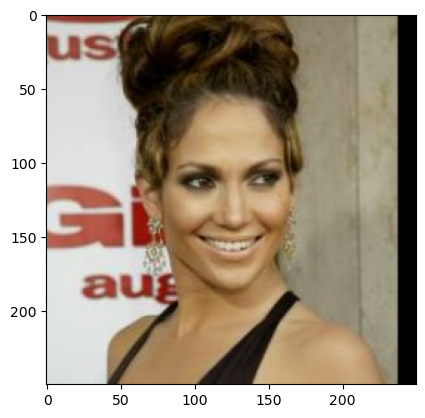

In [43]:
test_image = original_images[25]
plt.imshow(test_image)

In [44]:
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
if not skip_intermediate_demo:
    test_image_face_detection_result

In [45]:
test_image.shape

(250, 250, 3)

In [46]:
test_image_landmarks_relative_full = test_image_face_detection_result.keypoints[0][:4]
test_image_landmarks_absolute_full = (test_image_landmarks_relative_full * 250).astype(np.int32)
if not skip_intermediate_demo:
    test_image_landmarks_relative_full

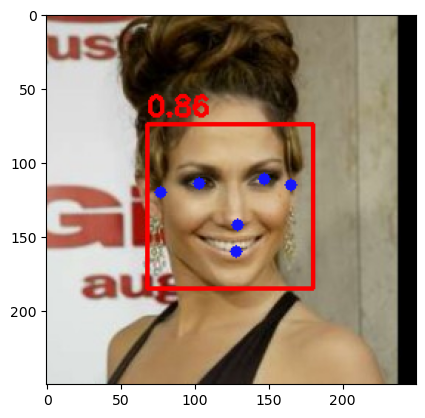

In [47]:
test_image_face = test_image.copy()
test_image_face = blazeface_model.draw_detections_single_image(test_image_face, test_image_face_detection_result)
plt.imshow(test_image_face)

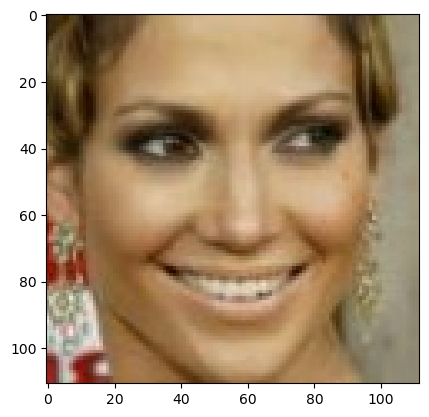

In [48]:
crop_face = SimpleFaceAlignment()
test_image_cropped, xmin, ymin = crop_face.crop(test_image, test_image_face_detection_result, 250,250)
test_image_cropped = test_image_cropped[0][:112,:112]
plt.imshow(test_image_cropped)

In [49]:
arcface_align = ArcFaceAlignment()
test_image_align_result = arcface_align.crop_and_align(test_image, test_image_face_detection_result)
test_image_align_result

AlignedFaceResults(
  num_faces=1,  # Number of detected faces
  eye_coordinates=None,  # (Left eye, Right eye)(from viewer perspective) coordinates for each face (x,y)
  rotation_angles=None,  # Rotation angles for each face alignment
  relative_face_sizes=[0.200704]  # Relative size of each face compared to the original image
)

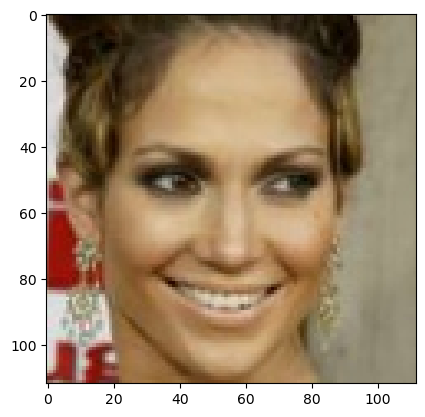

In [50]:
plt.imshow(test_image_align_result.aligned_faces[0])

### Test transformations

In [51]:
if not skip_intermediate_demo:
    face_detection_results = []
    face_transformation_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_transformation_results.append(arcface_align.crop_and_align(image, face_detection_results[idx]))
        else:
            face_transformation_results.append(None)
        

In [52]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_transformation_results, max_faces=30, start=40)

In [53]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=30, start=40)

## Face normalization (optional)

I can use a face mesh model like the one from [MediaPipe](https://github.com/google/mediapipe/blob/master/docs/solutions/face_mesh.md) to normalize faces, as shown [here](https://sefiks.com/2022/05/29/normalization-for-facial-recognition-with-mediapipe/). This probably gives better results, since the bounding boxes and landmarks from BlazeFace are not super accurate.

In [54]:
from src.face_alignment import FaceMeshAlignment

In [55]:
face_mesh_model = FaceMeshAlignment(crop=True)

In [56]:
test_image = original_images[18]
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
test_image_aligned_faces = face_aligner.crop_and_align(test_image, test_image_face_detection_result)

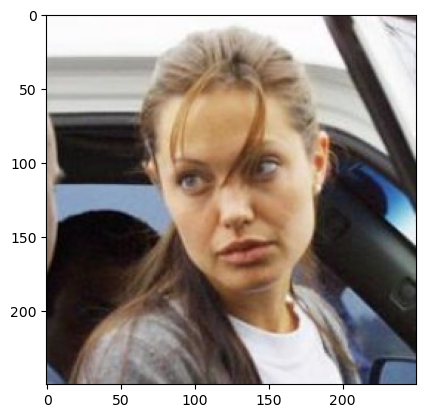

In [57]:
plt.imshow(test_image)

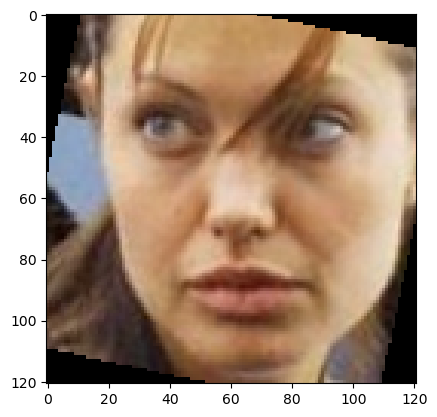

In [58]:
plt.imshow(test_image_aligned_faces.aligned_faces[0])

In [59]:
test_image_normalized_faces = face_mesh_model.normalize_faces(test_image, test_image_face_detection_result)

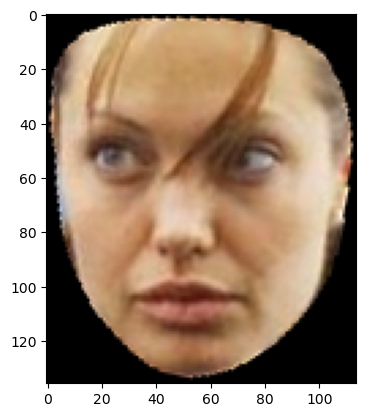

In [60]:
plt.imshow(test_image_normalized_faces.aligned_faces[0])

In [61]:
# run face detection and alignment on all images again
if not skip_intermediate_demo:
    face_detection_results = []
    face_normalization_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_normalization_results.append(face_mesh_model.normalize_faces(image, face_detection_results[idx]))
        else:
            face_normalization_results.append(None)

In [62]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=20)

In [63]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=20)

In [64]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=20, start=20)

In [65]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=20, start=20)

In [66]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=100, start=100)

## Face embeddings

In [67]:
from src.mobilefacenet import MobileFaceNet

In [68]:
mobilefacenet_model = MobileFaceNet(model_type="ente_web")
# mobilefacenet_quantized_model = MobileFaceNet(model_type="quantized")

In [69]:
mobilefacenet_model.interpreter.get_input_details()

[{'name': 'input',
  'index': 369,
  'shape': array([  1, 112, 112,   3], dtype=int32),
  'shape_signature': array([  1, 112, 112,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [70]:
mobilefacenet_model.interpreter.get_output_details()

[{'name': 'embeddings',
  'index': 368,
  'shape': array([  1, 192], dtype=int32),
  'shape_signature': array([  1, 192], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [71]:
# run face detection and alignment/normalization on all images again
face_detection_results = []
face_alignment_results = []
# face_normalization_results = []

for idx in tqdm(range(original_images.shape[0])):
    image = original_images[idx]
    face_detection_results.append(blazeface_model.detect_faces(image))
    if face_detection_results[-1].boxes.shape[0] > 0:
        face_alignment_results.append(arcface_align.crop_and_align(image, face_detection_results[idx]))
        # face_normalization_results.append(face_mesh_model.normalize_faces(image, face_detection_results[idx]))
    else:
        face_alignment_results.append(None)
        # face_normalization_results.append(None)

100%|██████████| 1849/1849 [00:09<00:00, 189.68it/s]


In [72]:
# create face embeddings using unquantized MobileFaceNet model
face_embeddings = []
# face_embeddings_normalized = []

for idx in tqdm(range(original_images.shape[0])):
    if (face_alignment_results[idx] is not None): # if face was detected
        if (face_alignment_results[idx].num_faces ==1): # if only one face was detected
            face_embeddings.append(mobilefacenet_model.extract_embedding(face_alignment_results[idx].aligned_faces[0]))
        else:
            face_embeddings.append(None)
    else:
        face_embeddings.append(None)
    # if (face_normalization_results[idx] is not None): # if face was detected
    #     if (face_normalization_results[idx].num_faces ==1): # if only one face was detected
    #         face_embeddings_normalized.append(mobilefacenet_model.extract_embedding(face_normalization_results[idx].aligned_faces[0]))

100%|██████████| 1849/1849 [00:11<00:00, 156.97it/s]


In [73]:
len(face_embeddings)

1849

In [74]:
face_embeddings_squeezed = [array[0] if array is not None else None for array in face_embeddings]

## Indexing the embeddings

### Quick approach with pandas

In [75]:
import sklearn

In [76]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

In [77]:
face_embeddings_used = face_embeddings

# filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings) if arr is not None]
filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings_used) if arr is not None]

# Separate indices and data into two lists
original_indices, filtered_data_arrays = zip(*filtered_embeddings)
true_labels = y[np.array(original_indices)]
# Create a pandas DataFrame from the data arrays
df_embeddings = pd.DataFrame(filtered_data_arrays)

# Add the original index column
df_embeddings['original_index'] = original_indices

# Calculate the cosine distance matrix
temp = time.time()
cosine_dist_matrix = cosine_distances(df_embeddings.drop(columns=['original_index'])).astype(np.float64)
cosine_distance_time = time.time() - temp
temp = time.time()
cosine_dist_matrix_more_precise = pairwise_distances(df_embeddings.drop(columns=['original_index']), metric='cosine').astype(np.float64)
cosine_pairwise_distance_time = time.time() - temp

norm_data = normalize(df_embeddings.drop(columns=['original_index']), norm='l2', axis=1)

In [78]:
df_embeddings

0         1         2         3         4         5         6   
0     0.009314  0.001382 -0.003652 -0.001475  0.000743  0.036704  0.092629  \
1    -0.002902 -0.014146 -0.001418 -0.008528 -0.002727  0.042162 -0.050622   
2     0.012616 -0.015245  0.007183  0.000041  0.001022  0.060275  0.072687   
3     0.009618 -0.013377  0.003181 -0.012119 -0.006410 -0.045413  0.018662   
4     0.011001 -0.011901  0.001210 -0.001958  0.002666  0.074894  0.082548   
...        ...       ...       ...       ...       ...       ...       ...   
1695  0.002489  0.007901  0.011425 -0.001814 -0.006440 -0.078155 -0.020811   
1696 -0.005950  0.008702 -0.005568 -0.004890 -0.004121 -0.152256 -0.010990   
1697 -0.000059  0.005033  0.006484 -0.011017 -0.008349 -0.122338 -0.003586   
1698 -0.016646  0.007638  0.006743 -0.011516 -0.012557 -0.087465  0.061426   
1699 -0.016141  0.014482  0.006898  0.002974 -0.010575 -0.037528 -0.042132   

             7         8         9  ...       183       184       185   
0    -0.230481  0.103118 -0.021681  ... -0.001588 -0.091979  0.082631  \
1    -0.165539  0.097311  0.107295  ... -0.001939 -0.114446 -0.136809   
2    -0.212595  0.161480 -0.024267  ... -0.003586  0.004941  0.078138   
3    -0.279721  0.107208 -0.137389  ... -0.001344 -0.039693  0.039941   
4    -0.171582 -0.007015  0.100610  ... -0.004900 -0.143101  0.071896   
...        ...       ...       ...  ...       ...       ...       ...   
1695  0.312662  0.136581 -0.200862  ... -0.004679 -0.050534  0.135775   
1696  0.293751  0.150978 -0.200424  ... -0.002384  0.123659  0.252406   
1697  0.177197  0.108646 -0.117461  ... -0.005257  0.005491  0.097419   
1698  0.214937  0.096627 -0.068502  ...  0.001292  0.060471  0.143739   
1699  0.388815  0.103805 -0.143819  ... -0.006463  0.018750  0.120685   

           186       187       188       189       190           191   
0    -0.080856 -0.038219  0.185818  0.164693  0.017768 -5.560206e-03  \
1    -0.020422 -0.020108  0.025715  0.059372  0.008110 -2.957186e-03   
2    -0.079340 -0.019179  0.221892 -0.037696  0.017985 -2.983917e-03   
3    -0.048204 -0.036610  0.036872 -0.066056  0.016328  3.812601e-03   
4    -0.064035 -0.011857  0.246857  0.031667  0.021989 -1.241668e-02   
...        ...       ...       ...       ...       ...           ...   
1695 -0.087565  0.050370 -0.131911 -0.130834 -0.010001  1.507624e-03   
1696 -0.067355  0.061598 -0.200113 -0.050035 -0.011270 -6.368197e-03   
1697 -0.097420  0.028291 -0.079773 -0.093317 -0.005991  1.065395e-07   
1698 -0.048035  0.094429 -0.022882 -0.186887 -0.012145 -4.232432e-03   
1699 -0.087251  0.122103 -0.148607 -0.082616 -0.020749 -1.183382e-02   

      original_index  
0                  0  
1                  1  
2                  2  
3                  3  
4                  4  
...              ...  
1695            1844  
1696            1845  
1697            1846  
1698            1847  
1699            1848  

[1700 rows x 193 columns]

### Solid approach with sqlite

## Clustering

### HDBSCAN clustering

In [79]:
from hdbscan import HDBSCAN

In [80]:
# Perform HDBSCAN clustering

# # Try out values for the parameters
# minimum_cluster_size = 5
# minimum_samples = 1
# selection_epsilon = 0
# selection_method = 'eom'

# # My best values for the parameters
# minimum_cluster_size = 7
# minimum_samples = 1
# selection_epsilon = 0
# selection_method = 'eom'

# Default values for the parameters
minimum_cluster_size = 5
minimum_samples = 5
selection_epsilon = 0
selection_method = 'eom'

# # Shailesh's best values for the parameters
# minimum_cluster_size = 3
# minimum_samples = 5
# selection_epsilon = 0.6
# selection_method = 'leaf'

# # Standard euclidian distance metric
# clusterer_euclidian = HDBSCAN()
# cluster_labels_euclidian = clusterer_euclidian.fit_predict(df_embeddings.drop(columns=['original_index']))


# Cosine distance metric (precomputed via distance matrix (INEFFICIENT, but best accuracy)))
temp = time.time()
clusterer_precomp = HDBSCAN(metric='precomputed', min_cluster_size=minimum_cluster_size, min_samples=minimum_samples, cluster_selection_epsilon=selection_epsilon, cluster_selection_method=selection_method)
cluster_labels_cosine = clusterer_precomp.fit_predict(cosine_dist_matrix_more_precise)
hdbscan_cosine_time = time.time() - temp
hdbscan_cosine_time += min(cosine_distance_time, cosine_pairwise_distance_time)

# # Angular distance (similar to cosine) via euclidian with normalized data (possibly best balance of accuracy and memory efficiency)
temp = time.time()
clusterer_euclidian = HDBSCAN(min_cluster_size=minimum_cluster_size, min_samples=minimum_samples, cluster_selection_epsilon=selection_epsilon, cluster_selection_method=selection_method) # euclidean distance is the default
cluster_labels_angular = clusterer_euclidian.fit_predict(norm_data)
hdbscan_angular_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['cluster_label'] = cluster_labels_cosine

In [81]:
df_embeddings

0         1         2         3         4         5         6   
0     0.009314  0.001382 -0.003652 -0.001475  0.000743  0.036704  0.092629  \
1    -0.002902 -0.014146 -0.001418 -0.008528 -0.002727  0.042162 -0.050622   
2     0.012616 -0.015245  0.007183  0.000041  0.001022  0.060275  0.072687   
3     0.009618 -0.013377  0.003181 -0.012119 -0.006410 -0.045413  0.018662   
4     0.011001 -0.011901  0.001210 -0.001958  0.002666  0.074894  0.082548   
...        ...       ...       ...       ...       ...       ...       ...   
1695  0.002489  0.007901  0.011425 -0.001814 -0.006440 -0.078155 -0.020811   
1696 -0.005950  0.008702 -0.005568 -0.004890 -0.004121 -0.152256 -0.010990   
1697 -0.000059  0.005033  0.006484 -0.011017 -0.008349 -0.122338 -0.003586   
1698 -0.016646  0.007638  0.006743 -0.011516 -0.012557 -0.087465  0.061426   
1699 -0.016141  0.014482  0.006898  0.002974 -0.010575 -0.037528 -0.042132   

             7         8         9  ...       184       185       186   
0    -0.230481  0.103118 -0.021681  ... -0.091979  0.082631 -0.080856  \
1    -0.165539  0.097311  0.107295  ... -0.114446 -0.136809 -0.020422   
2    -0.212595  0.161480 -0.024267  ...  0.004941  0.078138 -0.079340   
3    -0.279721  0.107208 -0.137389  ... -0.039693  0.039941 -0.048204   
4    -0.171582 -0.007015  0.100610  ... -0.143101  0.071896 -0.064035   
...        ...       ...       ...  ...       ...       ...       ...   
1695  0.312662  0.136581 -0.200862  ... -0.050534  0.135775 -0.087565   
1696  0.293751  0.150978 -0.200424  ...  0.123659  0.252406 -0.067355   
1697  0.177197  0.108646 -0.117461  ...  0.005491  0.097419 -0.097420   
1698  0.214937  0.096627 -0.068502  ...  0.060471  0.143739 -0.048035   
1699  0.388815  0.103805 -0.143819  ...  0.018750  0.120685 -0.087251   

           187       188       189       190           191  original_index   
0    -0.038219  0.185818  0.164693  0.017768 -5.560206e-03               0  \
1    -0.020108  0.025715  0.059372  0.008110 -2.957186e-03               1   
2    -0.019179  0.221892 -0.037696  0.017985 -2.983917e-03               2   
3    -0.036610  0.036872 -0.066056  0.016328  3.812601e-03               3   
4    -0.011857  0.246857  0.031667  0.021989 -1.241668e-02               4   
...        ...       ...       ...       ...           ...             ...   
1695  0.050370 -0.131911 -0.130834 -0.010001  1.507624e-03            1844   
1696  0.061598 -0.200113 -0.050035 -0.011270 -6.368197e-03            1845   
1697  0.028291 -0.079773 -0.093317 -0.005991  1.065395e-07            1846   
1698  0.094429 -0.022882 -0.186887 -0.012145 -4.232432e-03            1847   
1699  0.122103 -0.148607 -0.082616 -0.020749 -1.183382e-02            1848   

      cluster_label  
0                11  
1                11  
2                11  
3                11  
4                11  
...             ...  
1695             23  
1696             23  
1697             23  
1698             23  
1699             23  

[1700 rows x 194 columns]

In [82]:
number_clusters_cosine = len(np.unique(cluster_labels_cosine))-1
ari_cosine = adjusted_rand_score(true_labels, cluster_labels_cosine)
ari_cosine_exnoise = adjusted_rand_score(true_labels[cluster_labels_cosine != -1], cluster_labels_cosine[cluster_labels_cosine != -1])
ami_cosine = adjusted_mutual_info_score(true_labels, cluster_labels_cosine)
ami_cosine_exnoise = adjusted_mutual_info_score(true_labels[cluster_labels_cosine != -1], cluster_labels_cosine[cluster_labels_cosine != -1])
percentage_noise_cosine = np.sum(cluster_labels_cosine==-1)/len(cluster_labels_cosine)*100

number_clusters_angular = len(np.unique(cluster_labels_angular))-1
ari_angular = adjusted_rand_score(true_labels, cluster_labels_angular)
ari_angular_exnoise = adjusted_rand_score(true_labels[cluster_labels_angular != -1], cluster_labels_angular[cluster_labels_angular != -1])
ami_angular = adjusted_mutual_info_score(true_labels, cluster_labels_angular)
ami_angular_exnoise = adjusted_mutual_info_score(true_labels[cluster_labels_angular != -1], cluster_labels_angular[cluster_labels_angular != -1])
percentage_noise_angular = np.sum(cluster_labels_angular==-1)/len(cluster_labels_angular)*100

In [83]:
print(f"Results for the cosine distance metric:\n")

print(f"Number of different clusters: {number_clusters_cosine}")
print(f"ARI score for clustering accuracy: {ari_cosine}")
print(f"ARI score excluding noise: {ari_cosine_exnoise}")
print(f"AMI score for clustering accuracy: {ami_cosine}")
print(f"AMI score excluding noise: {ami_cosine_exnoise}")
print(f"Percentage of faces clustered into noise: {percentage_noise_cosine:.2f}%")
print(f"Time needed for clustering: {hdbscan_cosine_time:.2f}s for cosine")

Results for the cosine distance metric:

Number of different clusters: 29
ARI score for clustering accuracy: 0.9954399060336122
ARI score excluding noise: 1.0
AMI score for clustering accuracy: 0.9881683779811249
AMI score excluding noise: 1.0
Percentage of faces clustered into noise: 0.88%
Time needed for clustering: 0.09s for cosine


To easily interpret ARI:
The Adjusted Rand Index (ARI) measures the similarity between two clusterings, with 1 indicating a perfect match and 0 implying agreement no better than random chance. A higher ARI value signifies greater similarity between the two clusterings, while a negative value indicates the agreement is worse than random chance.

I think the reason for the low accuracy and high amount of noise is the fact that HDBSCAN works less well on high-dimensional data. The embeddings are in 192 dimensions, while the documentation of HDBSCAN recommends usage for up to 50 a 100 dimensions. 

In [84]:
print(f"Results for the angular distance metric:\n")

print(f"Number of different clusters: {number_clusters_angular}")
print(f"ARI score for clustering accuracy: {ari_angular}")
print(f"ARI score excluding noise: {ari_angular_exnoise}")
print(f"AMI score for clustering accuracy: {ami_angular}")
print(f"AMI score excluding noise: {ami_angular_exnoise}")
print(f"Percentage of faces clustered into noise: {percentage_noise_angular:.2f}%")
print(f"Time needed for clustering: {hdbscan_angular_time:.2f}s for angular")

Results for the angular distance metric:

Number of different clusters: 29
ARI score for clustering accuracy: 0.9954399060336122
ARI score excluding noise: 1.0
AMI score for clustering accuracy: 0.9881683779811249
AMI score excluding noise: 1.0
Percentage of faces clustered into noise: 0.88%
Time needed for clustering: 0.72s for angular


In [85]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

In [86]:
def plot_tsne_clusters(distance_matrix, labels, figsize=(10, 8), n_components=2, metric='precomputed', init='random', random_state=42):
    # Perform t-SNE on the embeddings
    tsne = TSNE(n_components=n_components, metric=metric, init=init, random_state=random_state)
    embeddings_2d = tsne.fit_transform(distance_matrix)

    # Add the 2D embeddings to a DataFrame
    df_embeddings = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'cluster_label': labels})

    # Define the colormap
    n_clusters = len(np.unique(labels))
    if n_clusters <= 10:
        tab10_cmap = plt.get_cmap('tab10', np.unique(labels).size - 1)
        tab10_cmap_list = tab10_cmap(np.linspace(0, 1, np.unique(labels).size - 1))
        custom_cmap_list = np.vstack(([0.7, 0.7, 0.7, 1.], tab10_cmap_list))
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', custom_cmap_list)
    else:
        cmap = plt.get_cmap('nipy_spectral', np.unique(labels).size - 1)

    # Plot the clusters
    plt.figure(figsize=figsize)
    scatter = plt.scatter(df_embeddings['x'], df_embeddings['y'], c=df_embeddings['cluster_label'], cmap=cmap, s=50)
    plt.title("t-SNE visualization of clusters")

    # Add a legend for the cluster colors
    if n_clusters <= 10:
        labels = ["noise"] + [f"Cluster {i}" for i in range(1, n_clusters)]
        handles, _ = scatter.legend_elements()
        legend1 = plt.legend(handles, labels, loc="upper left", title="Clusters")
        plt.gca().add_artist(legend1)
    else:
        # Only show legend for noise
        noise_proxy = plt.scatter([], [], c='grey', s=50)
        plt.legend([noise_proxy], ["noise"], loc="upper left", title="Clusters")

    plt.show()

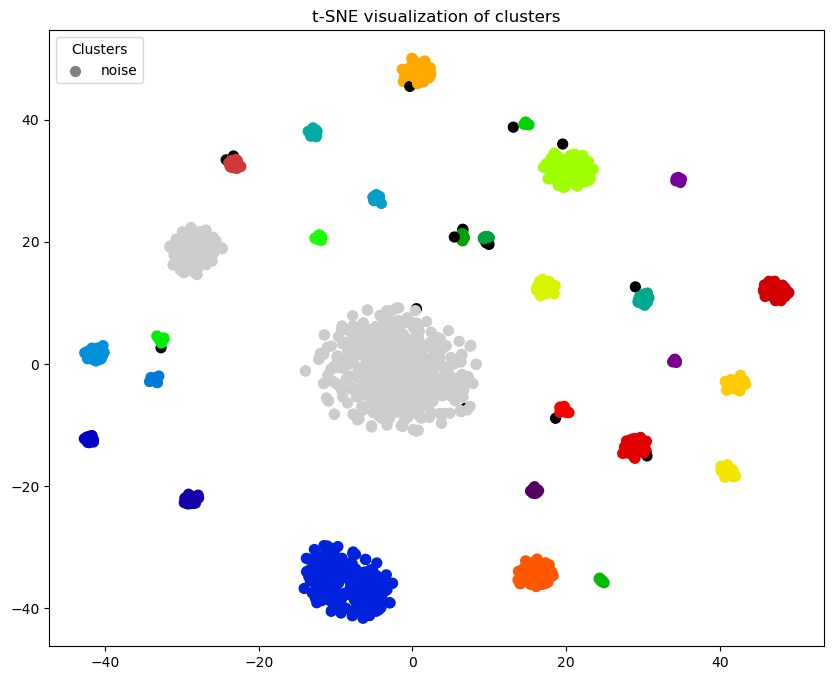

In [87]:
plot_tsne_clusters(cosine_dist_matrix, df_embeddings['cluster_label'])

Number of faces clustered into noise: 15 (out of 0/0 for min_samples=5/10)


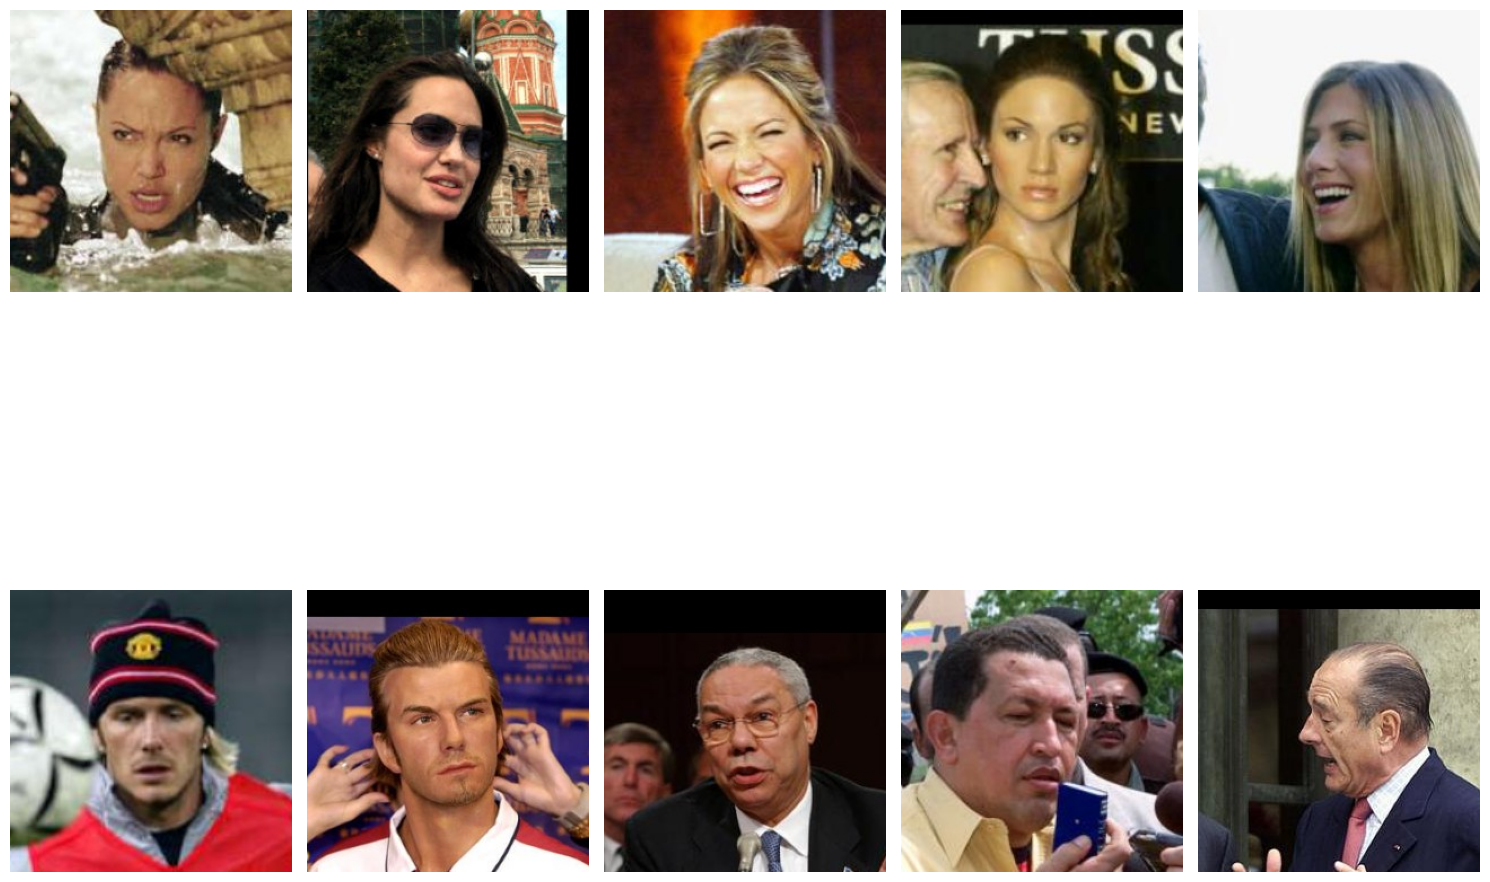

In [88]:
hdbscan_noise = list(df_embeddings[df_embeddings['cluster_label'] == -1]["original_index"].values)
print(f"Number of faces clustered into noise: {len(hdbscan_noise)} (out of {n_images_from_classes_smaller_than_5}/{n_images_from_classes_smaller_than_10} for min_samples=5/10)")
plot_original_faces(hdbscan_noise, max_faces=10)

### DBSCAN clustering

In [89]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [90]:
# Perform DBSCAN clustering

# test parameters
dbscan_epsilon = 0.3
dbscan_min_samples = 5 

# default parameters
# dbscan_epsilon = 0.5 # 0.5 is default
# dbscan_min_samples = 5 # 5 is default (integer values only)

temp = time.time()
dbscan = DBSCAN(eps=dbscan_epsilon, min_samples=dbscan_min_samples, metric='precomputed')
cluster_labels_dbscan = dbscan.fit_predict(cosine_dist_matrix)
dbscan_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['dbscan_cluster_label'] = cluster_labels_dbscan

In [91]:
number_clusters_dbscan = len(np.unique(cluster_labels_dbscan))-1
ari_dbscan = adjusted_rand_score(true_labels, cluster_labels_dbscan)
ari_dbscan_exnoise = adjusted_rand_score(true_labels[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
ami_dbscan = adjusted_mutual_info_score(true_labels, cluster_labels_dbscan)
ami_dbscan_exnoise = adjusted_mutual_info_score(true_labels[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
percentage_noise_dbscan = np.sum(cluster_labels_dbscan==-1)/len(cluster_labels_dbscan)*100

In [92]:
print(f"Results for the DBSCAN clustering:\n")

print(f"Number of different clusters: {number_clusters_dbscan}")
print(f"ARI score for clustering accuracy: {ari_dbscan:.4f}")
print(f"ARI score excluding noise: {ari_dbscan_exnoise:.4f}")
print(f"AMI score for clustering accuracy: {ami_dbscan:.4f}")
print(f"AMI score excluding noise: {ami_dbscan_exnoise:.4f}")
print(f"Percentage of faces clustered into noise: {percentage_noise_dbscan:.2f}%")
print(f"Time taken for DBSCAN clustering: {dbscan_time:.2f}s")

Results for the DBSCAN clustering:

Number of different clusters: 29
ARI score for clustering accuracy: 0.9885
ARI score excluding noise: 1.0000
AMI score for clustering accuracy: 0.9732
AMI score excluding noise: 1.0000
Percentage of faces clustered into noise: 2.12%
Time taken for DBSCAN clustering: 0.03s


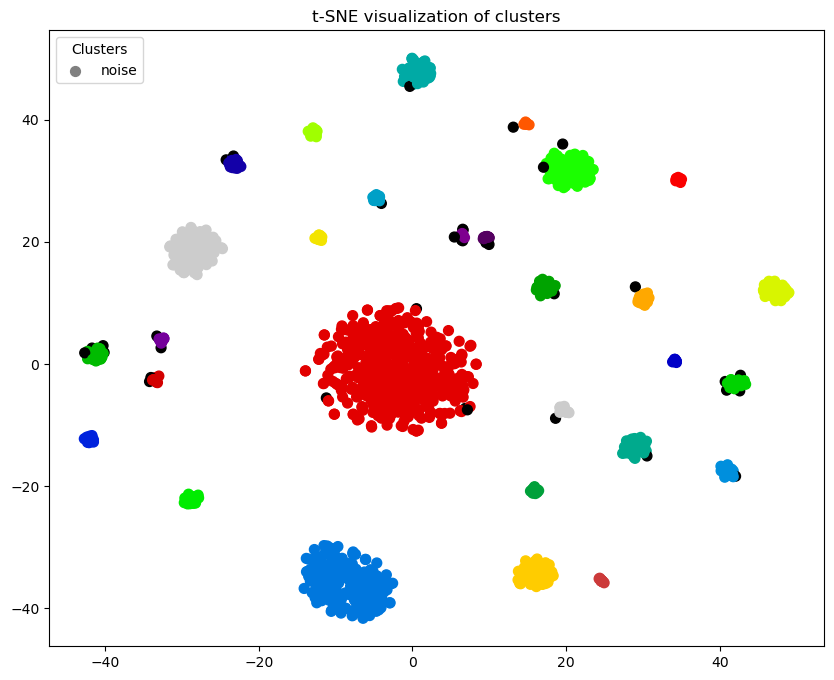

In [93]:
plot_tsne_clusters(cosine_dist_matrix, df_embeddings['dbscan_cluster_label'])

Number of faces clustered into noise: 36 (out of 0/0 for min_samples=5/10)


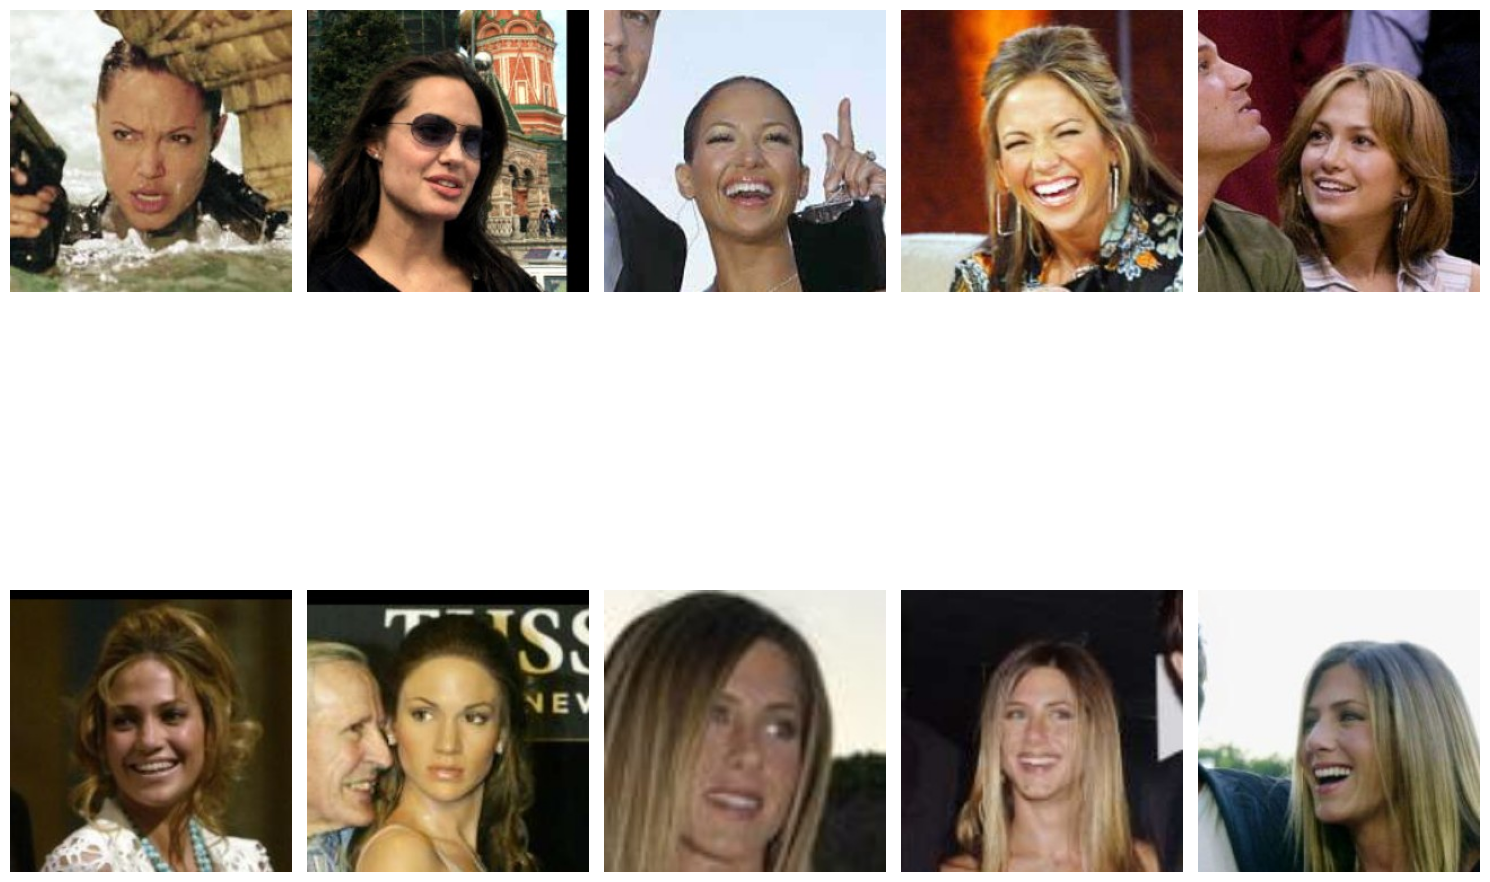

In [94]:
dbscan_noise = list(df_embeddings[df_embeddings['dbscan_cluster_label'] == -1]["original_index"].values)
print(f"Number of faces clustered into noise: {len(dbscan_noise)} (out of {n_images_from_classes_smaller_than_5}/{n_images_from_classes_smaller_than_10} for min_samples=5/10)")
plot_original_faces(dbscan_noise, max_faces=10)

### OPTICS

In [95]:
from sklearn.cluster import OPTICS

In [96]:
# Perform OPTICS (xi-steep method) clustering

# default parameters
minimum_samples_optics = 2 # 5 is default (integer values only)
minimum_cluster_size_optics = 7 # 0.05 is default (int)
maximum_eps_optics = np.inf # np.inf is default (float or None)
optics_method = 'xi' # 'xi' is default ('xi' or 'dbscan')
optics_dbscan_eps = 0.3 # 0.5 is default (float)
optics_xi = 0.05 # 0.05 is default (float)

temp = time.time()
optics = OPTICS(min_samples = minimum_samples_optics, max_eps= maximum_eps_optics, metric='cosine', cluster_method=optics_method, eps=optics_dbscan_eps, xi=optics_xi, min_cluster_size=minimum_cluster_size_optics)
cluster_labels_optics = optics.fit_predict(norm_data)
optics_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['optics_cluster_label'] = cluster_labels_optics

In [97]:
number_clusters_optics = len(np.unique(cluster_labels_optics))-1
ari_optics = adjusted_rand_score(true_labels, cluster_labels_optics)
ari_optics_exnoise = adjusted_rand_score(true_labels[cluster_labels_optics != -1], cluster_labels_optics[cluster_labels_optics != -1])
ami_optics = adjusted_mutual_info_score(true_labels, cluster_labels_optics)
ami_optics_exnoise = adjusted_mutual_info_score(true_labels[cluster_labels_optics != -1], cluster_labels_optics[cluster_labels_optics != -1])
percentage_noise_optics = np.sum(cluster_labels_optics==-1)/len(cluster_labels_optics)*100

In [98]:
print(f"Results for the OPTICS clustering:\n")

print(f"Number of different clusters: {number_clusters_optics}")
print(f"ARI score for clustering accuracy: {ari_optics:.4f}")
print(f"ARI score excluding noise: {ari_optics_exnoise:.4f}")
print(f"AMI score for clustering accuracy: {ami_optics:.4f}")
print(f"AMI score excluding noise: {ami_optics_exnoise:.4f}")
print(f"Percentage of faces clustered into noise: {percentage_noise_optics:.2f}%")
print(f"Time taken for OPTICS clustering: {optics_time:.2f}s")

Results for the OPTICS clustering:

Number of different clusters: 29
ARI score for clustering accuracy: 0.6492
ARI score excluding noise: 1.0000
AMI score for clustering accuracy: 0.7357
AMI score excluding noise: 1.0000
Percentage of faces clustered into noise: 30.59%
Time taken for OPTICS clustering: 6.66s


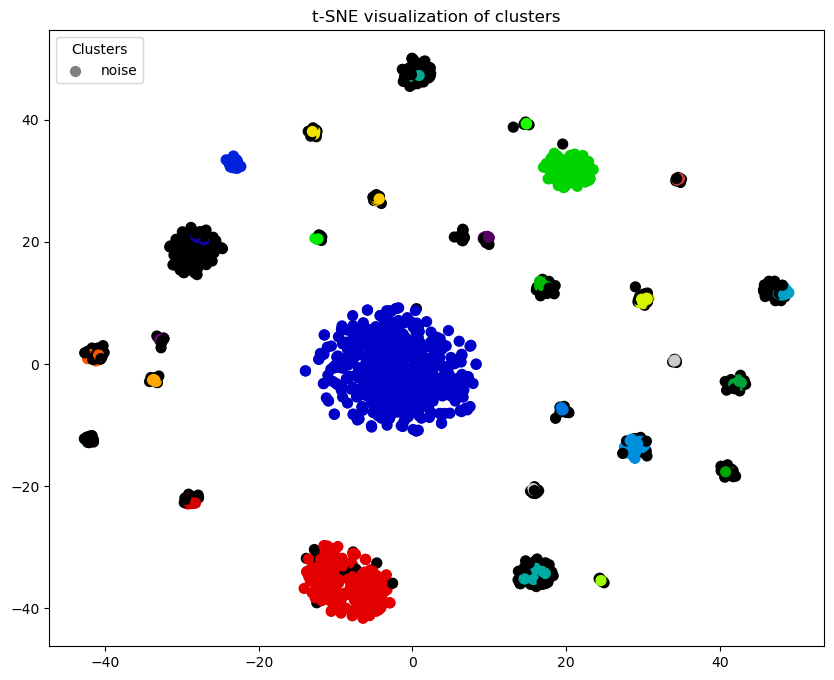

In [99]:
plot_tsne_clusters(cosine_dist_matrix, df_embeddings['optics_cluster_label'])

Number of faces clustered into noise: 520 (out of 0/0 for min_samples=5/10)


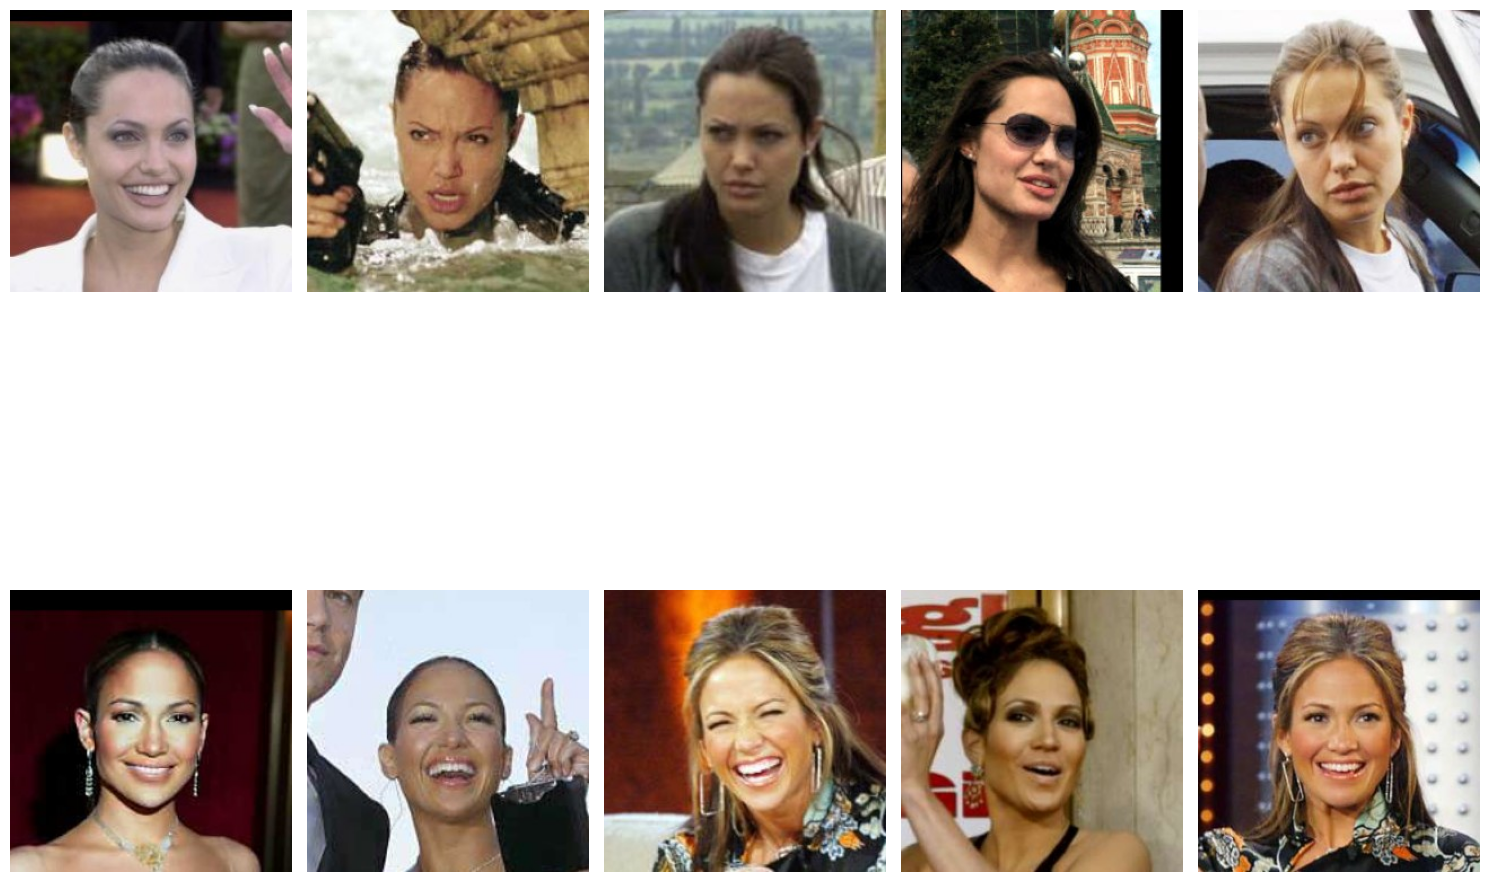

In [100]:
optics_noise = list(df_embeddings[df_embeddings['optics_cluster_label'] == -1]["original_index"].values)
print(f"Number of faces clustered into noise: {len(optics_noise)} (out of {n_images_from_classes_smaller_than_5}/{n_images_from_classes_smaller_than_10} for min_samples=5/10)")
plot_original_faces(optics_noise, max_faces=10)

### HDBSCAN vs DBSCAN

In [101]:
# print the latency of each clustering algorithm
print("Time taken for each algorithm:")
print(f"HDBSCAN (cosine): {hdbscan_cosine_time:.2f}s")
print(f"HDBSCAN (angular): {hdbscan_angular_time:.2f}s")
print(f"DBSCAN: {dbscan_time:.2f}s")
# print(f"OPTICS: {optics_time:.2f}s")


Time taken for each algorithm:
HDBSCAN (cosine): 0.09s
HDBSCAN (angular): 0.72s
DBSCAN: 0.03s


In [102]:
print("Scores for each algorithm:\n")

print("ARI scores:")
print(f"HDBSCAN (cosine): {ari_cosine:.4f}")
print(f"HDBSCAN (angular): {ari_angular:.4f}")
print(f"DBSCAN: {ari_dbscan:.4f}\n")

print("Percentage of faces clustered into noise:")
print(f"HDBSCAN (cosine): {percentage_noise_cosine:.2f}%")
print(f"HDBSCAN (angular): {percentage_noise_angular:.2f}%")
print(f"DBSCAN: {percentage_noise_dbscan:.2f}%\n")

print("ARI scores excluding noise:")
print(f"HDBSCAN (cosine): {ari_cosine_exnoise:.4f}")
print(f"HDBSCAN (angular): {ari_angular_exnoise:.4f}")
print(f"DBSCAN: {ari_dbscan_exnoise:.4f}\n")

print("AMI scores:")
print(f"HDBSCAN (cosine): {ami_cosine:.4f}")
print(f"HDBSCAN (angular): {ami_angular:.4f}")
print(f"DBSCAN: {ami_dbscan:.4f}\n")

print("Percentage of faces clustered into noise:")
print(f"HDBSCAN (cosine): {percentage_noise_cosine:.2f}%")
print(f"HDBSCAN (angular): {percentage_noise_angular:.2f}%")
print(f"DBSCAN: {percentage_noise_dbscan:.2f}%\n")

print("AMI scores excluding noise:")
print(f"HDBSCAN (cosine): {ami_cosine_exnoise:.4f}")
print(f"HDBSCAN (angular): {ami_angular_exnoise:.4f}")
print(f"DBSCAN: {ami_dbscan_exnoise:.4f}\n")


Scores for each algorithm:

ARI scores:
HDBSCAN (cosine): 0.9954
HDBSCAN (angular): 0.9954
DBSCAN: 0.9885

Percentage of faces clustered into noise:
HDBSCAN (cosine): 0.88%
HDBSCAN (angular): 0.88%
DBSCAN: 2.12%

ARI scores excluding noise:
HDBSCAN (cosine): 1.0000
HDBSCAN (angular): 1.0000
DBSCAN: 1.0000

AMI scores:
HDBSCAN (cosine): 0.9882
HDBSCAN (angular): 0.9882
DBSCAN: 0.9732

Percentage of faces clustered into noise:
HDBSCAN (cosine): 0.88%
HDBSCAN (angular): 0.88%
DBSCAN: 2.12%

AMI scores excluding noise:
HDBSCAN (cosine): 1.0000
HDBSCAN (angular): 1.0000
DBSCAN: 1.0000

